# BoomBikes Case Study

The purpose of this case study is to model the demand for shared bikes with the available independent variables.
It will help the management to understand how exactly the demands vary with different features. They can then accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. 

Further, the model will be a good way for management to understand the demand dynamics of a new market. 

In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utils

In [2]:
def pair_plot(data, x_vars, y_var, num_plots_in_row=4, fig_size=(18, 15), plot_type='scatter'):
    num_rows = math.ceil(len(x_vars) / num_plots_in_row)
    
    fig, axs = plt.subplots(num_rows, num_plots_in_row)
    
    if num_rows <= 1:
        axs = [axs]
        
    for i in range(num_rows):
        for j in range(num_plots_in_row):
            
            # if all variables have been plotted
            if (i * num_plots_in_row + j) >= len(x_vars): break
            
            if plot_type == 'scatter':
                pr = stats.pearsonr(data[x_vars[i*num_plots_in_row + j]], data[y_var])[0]
                sns.regplot(data=data, x=x_vars[i*num_plots_in_row + j], y=y_var, ax=axs[i][j])
                axs[i][j].title.set_text(f"Correlation coeffient = {pr:.2f}")
                
            elif plot_type == 'box':
                sns.boxplot(data=data, x=x_vars[i*num_plots_in_row + j], y=y_var, ax=axs[i][j])
    
    fig.set_size_inches(*fig_size)
    plt.show()

# Load the Dataset

In [3]:
data = pd.read_csv('day.csv')

print(f"Number of records: {data.shape[0]} and columns: {data.shape[1]}\n")

data.head(2)

Number of records: 730 and columns: 16



,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


# EDA

## # check nulls & data types

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


Note:
+ Data does not contain any null values
+ Convert date column to datetime
+ season is categorical, need to be one-hot-encoded
+ yr can be used as it is since it is ordinal
+ weathersit is also categorical, need to be one-hot-encoded
+ casual and registered need to be dropped as they will lead to target leakage, as target variable 'cnt' is sum of 'casual' & 'registered'
+ instant is index/id column and can be dropped
+ year month & week day variables are already in the data and hence can be dropped

### convert date to datetime

In [5]:
data['dteday'] = pd.to_datetime(data['dteday'])
data['dteday'].head(5)

0   2018-01-01
1   2018-02-01
2   2018-03-01
3   2018-04-01
4   2018-05-01
Name: dteday, dtype: datetime64[ns]

### fix season column

In [6]:
# check the distribution
data['season'].value_counts(normalize=True)

3    0.257534
2    0.252055
1    0.246575
4    0.243836
Name: season, dtype: float64

In [7]:
season_maping = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
data['season'] = data['season'].apply(lambda x: season_maping.get(x, None))
data['season'].value_counts(normalize=True, dropna=False)

fall      0.257534
summer    0.252055
spring    0.246575
winter    0.243836
Name: season, dtype: float64

### fix weathersit column

In [8]:
# check the distribution
data['weathersit'].value_counts(normalize=True)

1    0.634247
2    0.336986
3    0.028767
Name: weathersit, dtype: float64

In [9]:
weathersit_maping = {1: 'clr_partly_cloudy', 2: 'mist_cloudy', 3: 'light_rain_snow', 4: 'heavy_rain_snow'}
data['weathersit'] = data['weathersit'].apply(lambda x: weathersit_maping.get(x, None))
data['weathersit'].value_counts(normalize=True, dropna=False)

clr_partly_cloudy    0.634247
mist_cloudy          0.336986
light_rain_snow      0.028767
Name: weathersit, dtype: float64

### drop columns

In [10]:
data.drop(['casual', 'registered', 'instant'], axis=1, inplace=True)
data.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2018-01-01,spring,0,1,0,6,0,mist_cloudy,14.110847,18.18125,80.5833,10.749882,985
1,2018-02-01,spring,0,1,0,0,0,mist_cloudy,14.902598,17.68695,69.6087,16.652113,801


## check values

In [11]:
data.describe(include='all').T.fillna('-')

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
dteday,730.0,730,2019-10-25 00:00:00,1,2018-01-01 00:00:00,2019-12-31 00:00:00,-,-,-,-,-,-,-
season,730.0,4,fall,188,-,-,-,-,-,-,-,-,-
yr,730.0,-,-,-,-,-,0.5,0.500343,0,0,0.5,1,1
mnth,730.0,-,-,-,-,-,6.52603,3.45022,1,4,7,10,12
holiday,730.0,-,-,-,-,-,0.0287671,0.167266,0,0,0,0,1
weekday,730.0,-,-,-,-,-,2.99726,2.00616,0,1,3,5,6
workingday,730.0,-,-,-,-,-,0.683562,0.465405,0,0,1,1,1
weathersit,730.0,3,clr_partly_cloudy,463,-,-,-,-,-,-,-,-,-
temp,730.0,-,-,-,-,-,20.3193,7.50673,2.42435,13.8119,20.4658,26.8806,35.3283
atemp,730.0,-,-,-,-,-,23.7263,8.15031,3.95348,16.8897,24.3682,30.4458,42.0448


## Get Plots

### Time series of Demand


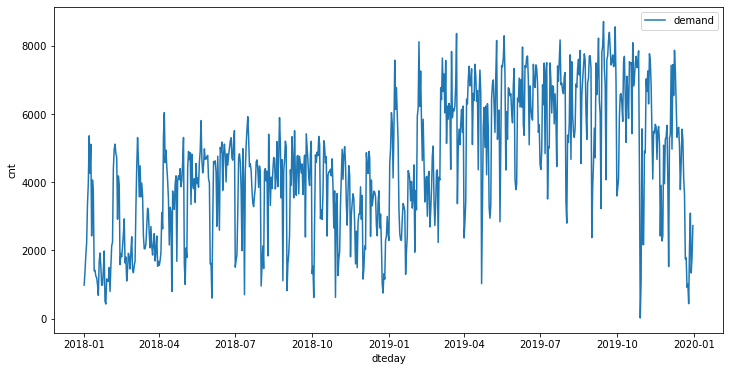

In [12]:
fig = plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='dteday', y='cnt', label='demand')

### Distribution of the cnt

C:\Users\prate\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


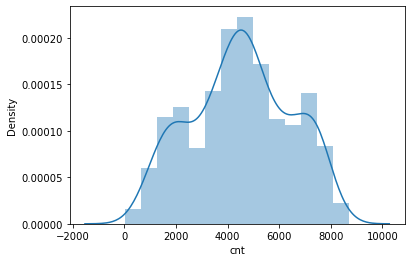

In [13]:
sns.distplot(data['cnt'])

In [14]:
print(f"Skew is: {skew(data['cnt']): .2f}")
print(f"Kurtosis is: {kurtosis(data['cnt']): .2f}")

Skew is: -0.05
Kurtosis is: -0.81


Note:
+ Cnt variable has slight negative skew, but it is very small
+ Also, data is less than normally distributed, that is, it is more spreaded

### For Numeric Features

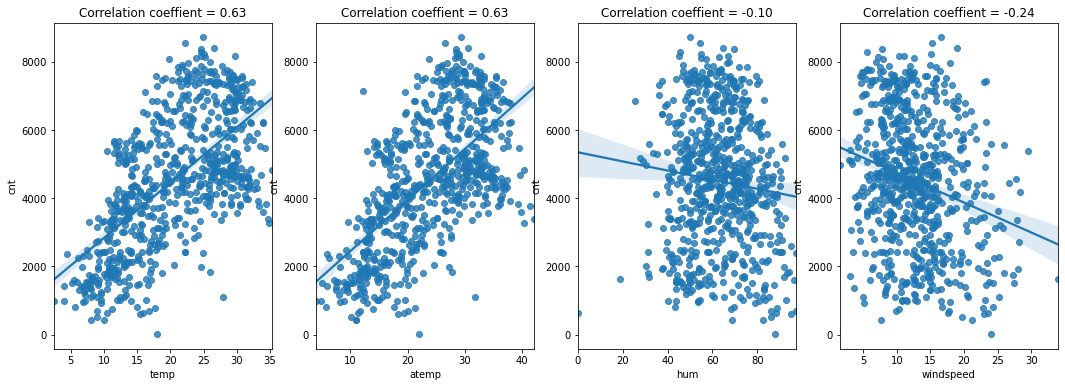

In [15]:
pair_plot(x_vars=['temp', 'atemp', 'hum', 'windspeed'],
             y_var='cnt',
             data=data,
             fig_size=(18, 6))

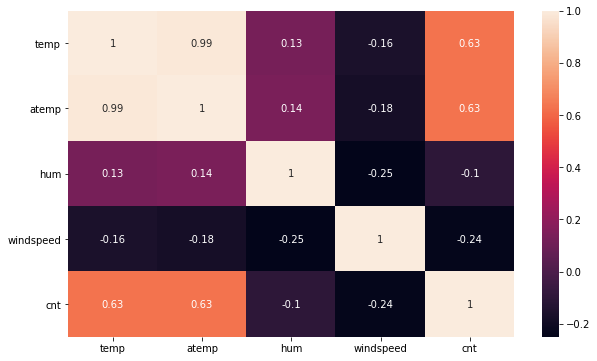

In [16]:
corr = data[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
corr = corr.apply(lambda x: round(x, 2))


fig = plt.figure()
sns.heatmap(corr, annot=True)
fig.set_size_inches(10, 6)

Observations:
+ There is seems to be some correlation between temp & cnt and atemp & cnt

### For Categorical Features

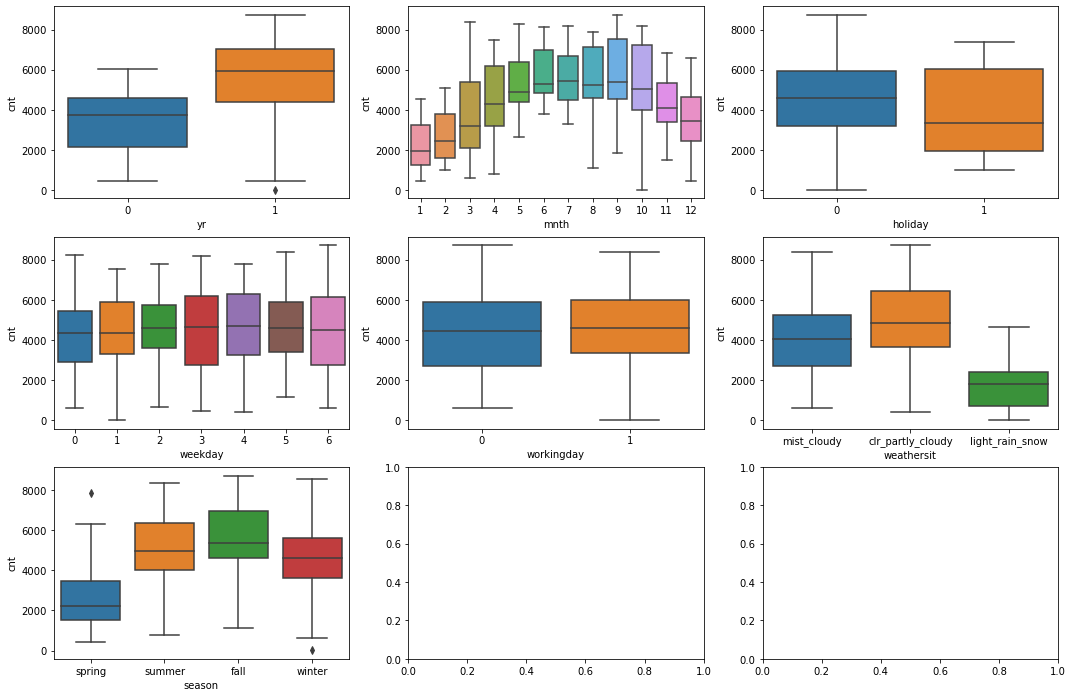

In [17]:
pair_plot(x_vars=[ 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'season'],
             y_var='cnt',
             data=data,
             plot_type='box',
             num_plots_in_row=3,
             fig_size=(18, 12))

Observations:
+ Year 2019 has more bookings as compared to 2018
+ Nov, Dec, Jan & Feb months have lower bookings
+ Holidays have lower bookings
+ bookings is similar across weekdays
+ light_rain_snow has much less number of bookings, while Clear or Partly Clouded has the highest
+ Spring has lower number of bookings

# Feature Engineering

## Train & Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# select the features and target variable
X = data[['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'season']]
y = data['cnt']

Note:
+ Since temp and atemp are highly correlated not including atemp

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

print(f"Training shapes - X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing shapes - X: {X_test.shape}, y: {y_test.shape}")

Training shapes - X: (584, 11), y: (584,)
Testing shapes - X: (146, 11), y: (146,)


## Encoding Categorical Variables

In [21]:
from sklearn.preprocessing import OneHotEncoder

### encode season categories

In [22]:
# train the encoder
season_encoder = OneHotEncoder(drop='first', handle_unknown='error').fit(X_train[['season']])

# fit on training data
train_season = pd.DataFrame(data=season_encoder.transform(X_train[['season']]).toarray(), columns=season_encoder.get_feature_names(['season']))

print(f"Shape is: {train_season.shape}")
train_season.head(1)

Shape is: (584, 3)


,season_spring,season_summer,season_winter
0,0.0,0.0,0.0


In [23]:
# get the season on test data
test_season = pd.DataFrame(data=season_encoder.transform(X_test[['season']]).toarray(), columns=season_encoder.get_feature_names(['season']))

print(f"Shape is: {test_season.shape}")
test_season.head(1)

Shape is: (146, 3)


,season_spring,season_summer,season_winter
0,0.0,1.0,0.0


### encode weather column

In [24]:
# train the encoder
weather_encoder = OneHotEncoder(drop='first', handle_unknown='error').fit(X_train[['weathersit']])

# fit on training data
train_weather = pd.DataFrame(data=weather_encoder.transform(X_train[['weathersit']]).toarray(), columns=weather_encoder.get_feature_names(['weathersit']))

print(f"Shape is: {train_weather.shape}")
train_weather.head(1)

Shape is: (584, 2)


,weathersit_light_rain_snow,weathersit_mist_cloudy
0,0.0,1.0


In [25]:
# get the season on test data
test_weather = pd.DataFrame(data=weather_encoder.transform(X_test[['weathersit']]).toarray(), columns=weather_encoder.get_feature_names(['weathersit']))

print(f"Shape is: {test_weather.shape}")
test_weather.head(1)

Shape is: (146, 2)


,weathersit_light_rain_snow,weathersit_mist_cloudy
0,0.0,0.0


### create final categorical dataframe

In [26]:
train_categories = pd.concat([train_season, train_weather], axis=1)

print(f"Shape is: {train_categories.shape}")
train_categories.head(1)

Shape is: (584, 5)


,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,0.0,0.0,0.0,0.0,1.0


In [27]:
test_categories = pd.concat([test_season, test_weather], axis=1)

print(f"Shape is: {test_categories.shape}")
test_categories.head(1)

Shape is: (146, 5)


,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,0.0,1.0,0.0,0.0,0.0


## Standardize numerical columns

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
# filter numerical columns
numeric_columns = [col for col in X_train if col not in ('season', 'weathersit')]
print(numeric_columns)

['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']


In [30]:
# train scaler
scaler = StandardScaler()
scaler.fit(X_train[numeric_columns])

# transform training data
train_numeric = pd.DataFrame(scaler.transform(X_train[numeric_columns]), columns=numeric_columns)

print(f"Shape is: {train_numeric.shape}")
train_numeric.head(1)

Shape is: (584, 9)


,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed
0,-1.024267,0.703198,5.45315,-0.973232,-1.434431,0.941813,0.896189,1.094484,0.352149


In [31]:
# transform test data
test_numeric = pd.DataFrame(scaler.transform(X_test[numeric_columns]), columns=numeric_columns)

print(f"Shape is: {test_numeric.shape}")
test_numeric.head(1)

Shape is: (146, 9)


,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed
0,0.976308,-0.756176,-0.18338,1.508722,-1.434431,-0.036858,0.045115,-0.927548,0.061038


In [32]:
# ## Skipping the Scaling of Numeric Features

In [33]:
# train_numeric = X_train[numeric_columns].reset_index(drop=True)
# test_numeric = X_test[numeric_columns].reset_index(drop=True)

## Create Final Dataset

In [34]:
# for training data
X_train_processed = pd.concat([train_numeric, train_categories], axis=1)
y_train.reset_index(drop=True, inplace=True)
X_train_processed.head(5)

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,-1.024267,0.703198,5.45315,-0.973232,-1.434431,0.941813,0.896189,1.094484,0.352149,0.0,0.0,0.0,0.0,1.0
1,-1.024267,1.578823,-0.18338,1.012331,0.697141,-1.029248,-0.922897,-0.063061,-1.144131,0.0,0.0,1.0,0.0,0.0
2,0.976308,1.578823,-0.18338,-0.476841,0.697141,-0.142044,-0.072002,0.695937,-0.163360,0.0,0.0,1.0,0.0,0.0
3,0.976308,-1.048051,-0.18338,1.508722,-1.434431,0.068329,0.150533,0.851250,-1.011134,1.0,0.0,0.0,0.0,1.0
4,-1.024267,-0.464301,-0.18338,-0.476841,0.697141,0.329003,0.357555,1.428559,1.216404,0.0,1.0,0.0,0.0,1.0


In [35]:
# for test data
X_test_processed = pd.concat([test_numeric, test_categories], axis=1)
y_test.reset_index(drop=True, inplace=True)
X_test_processed.head(5)

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,0.976308,-0.756176,-0.18338,1.508722,-1.434431,-0.036858,0.045115,-0.927548,0.061038,0.0,1.0,0.0,0.0,0.0
1,-1.024267,-0.464301,-0.18338,-1.469622,-1.434431,0.909802,0.833767,1.293755,0.368750,0.0,1.0,0.0,0.0,0.0
2,-1.024267,0.995073,-0.18338,-1.469622,-1.434431,-1.001808,-0.985369,-0.077711,-0.130104,0.0,0.0,1.0,0.0,0.0
3,-1.024267,1.578823,-0.18338,0.515940,0.697141,-0.430158,-0.337451,0.862974,-1.858961,1.0,0.0,0.0,0.0,1.0
4,0.976308,-0.464301,-0.18338,0.515940,0.697141,0.978401,0.931327,-0.997880,0.119343,0.0,1.0,0.0,0.0,0.0


## Check Correlation

In [36]:
corr = X_train_processed.corr()
corr = corr.apply(lambda x: round(x, 2))

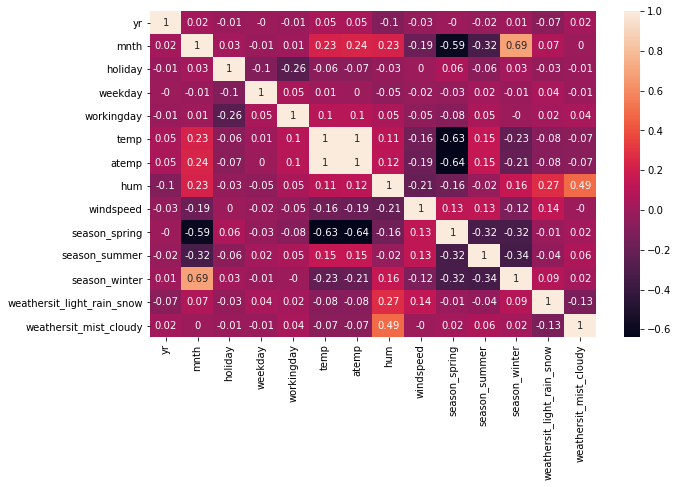

In [37]:
fig = plt.figure()
sns.heatmap(corr, annot=True)
fig.set_size_inches(10, 6)

Note:
+ temp and atemp are highly correlated
+ season_winter is correlated with month, which is kinda expected, but it is only ~70%
+ light_rain_snow is correlated with month, which is kinda expected, but it is only ~70%
+ day of year and month are correlated nit only slighly ~60%

## Multi-collinearity

In [38]:
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train_processed.values, i) for i in range(X_train_processed.shape[1])]
vif['variable'] = X_train_processed.columns
vif.sort_values('VIF', ascending=False, inplace=True)

vif.head(3)

,VIF,variable
6,179.187250,atemp
5,177.224570,temp
1,3.627761,mnth


Note:
+ Dropping atemp

In [39]:
# dropping from traind data
X_train_processed.drop('atemp', axis=1, inplace=True)
X_train_processed.head(2)

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,-1.024267,0.703198,5.45315,-0.973232,-1.434431,0.941813,1.094484,0.352149,0.0,0.0,0.0,0.0,1.0
1,-1.024267,1.578823,-0.18338,1.012331,0.697141,-1.029248,-0.063061,-1.144131,0.0,0.0,1.0,0.0,0.0


In [40]:
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train_processed.values, i) for i in range(X_train_processed.shape[1])]
vif['variable'] = X_train_processed.columns
vif.sort_values('VIF', ascending=False, inplace=True)

vif.head(3)

,VIF,variable
1,3.626244,mnth
8,2.701177,season_spring
10,2.661921,season_winter


Note:
+ mnth has VIF of 3.6, which is higher than 2 but not very much

So, proceeding without dropping any other variables

## Modeling

### 1st Model Version

In [41]:
X_train_processed = sm.add_constant(X_train_processed)

lm_1 = sm.OLS(y_train.values, X_train_processed).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     201.7
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          2.39e-203
Time:                        18:51:40   Log-Likelihood:                -4750.8
No. Observations:                 584   AIC:                             9530.
Df Residuals:                     570   BIC:                             9591.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Note:
+ Month coefficient is not statistically significant and its VIF was also >2, so, dropping it

### 2nd Model Version

In [42]:
# dropping 'Month' from train data
X_train_processed.drop('mnth', axis=1, inplace=True)
X_train_processed.head(2)

,const,yr,holiday,weekday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,1.0,-1.024267,5.45315,-0.973232,-1.434431,0.941813,1.094484,0.352149,0.0,0.0,0.0,0.0,1.0
1,1.0,-1.024267,-0.18338,1.012331,0.697141,-1.029248,-0.063061,-1.144131,0.0,0.0,1.0,0.0,0.0


In [43]:
lm_2 = sm.OLS(y_train.values, X_train_processed).fit()
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     217.9
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          4.51e-204
Time:                        18:51:40   Log-Likelihood:                -4751.9
No. Observations:                 584   AIC:                             9530.
Df Residuals:                     571   BIC:                             9587.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Feature Coefficients Plot

Text(0.5, 1.0, 'Model Features and their Coefficients')

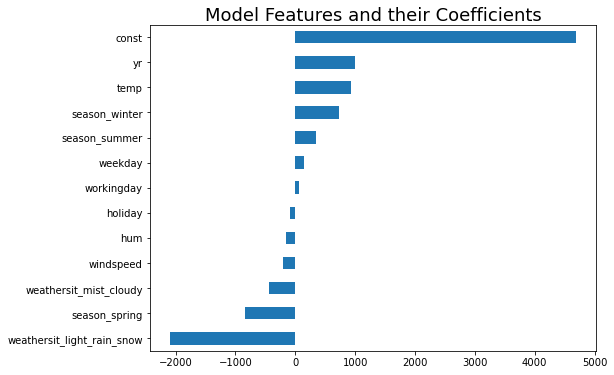

In [44]:
# sort the parameters
parameters = lm_2.params
parameters.sort_values(inplace=True)

fig = plt.figure(figsize=(8, 6))
# plot the parameters
parameters.plot(kind='barh')
plt.title("Model Features and their Coefficients", fontsize=18, pad=3)

In [45]:
parameters

weathersit_light_rain_snow   -2093.857523
season_spring                 -836.684278
weathersit_mist_cloudy        -436.708166
windspeed                     -213.122383
hum                           -155.290980
holiday                        -91.292816
workingday                      64.646091
weekday                        136.461903
season_summer                  338.433052
season_winter                  732.205850
temp                           935.638458
yr                             992.408969
const                         4685.346627
dtype: float64

Observations:
+ R_squared & Adjusted R_squared both are close to 82%, hence the model contains right amount of variables
+ Constant: that is base demand is 4,685.34
+ Light rain and snow that is when there is any rain or snow, it has negative impact on negative impact on the demand, that is, it reduces demand by 2,093.85. Also, this has the highest impact on the demand.
+ Year also have significant coefficient of 992, indicating that in 2019 demand is higher by 992 as compared to 2018.
+ Temperature have a positive coefficient value indicating that as the temperature rised more people demand for the ride. It could be due to the fact that people may not prefer to walk or take public transport during high temperatures. Its coefficient is 935 i.e. unit change in temperature will lead to rise in demand by 935.
+ Winters also lead to higher demand as people might not prefer to walk in cold. It has coeffient value of 732, that is in winters demand rised by 732.
+ Spring season and Mist or Cloudy weather have negative impact on the demand. In spring demand reduced by ~800, while in Cloudy weather it reduces by ~400 bookings
+ All the other coefficients are also statistically significant

# Residual Analysis

In [46]:
# get predictions
y_train_pred = lm_2.predict(X_train_processed)

# get residuals
y_train_residuals = (y_train - y_train_pred)

## Actual vs. Predicted

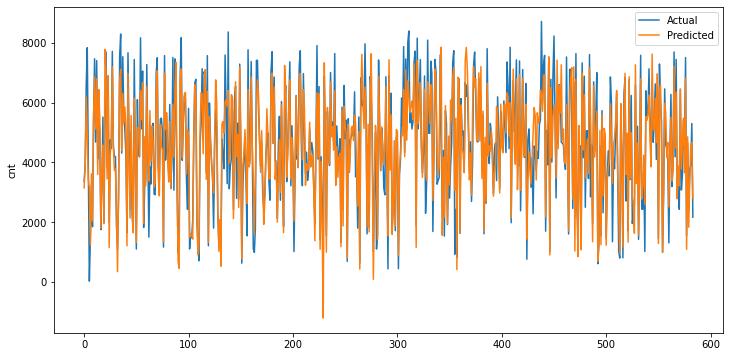

In [47]:
index = [i for i in range(X_train_processed.shape[0])]

fig = plt.figure(figsize=(12, 6))
sns.lineplot(x=index, y=y_train, label='Actual')
sns.lineplot(x=index, y=y_train_pred, label='Predicted')

Note:
+ Predicted values are closer to Actual values

## Check if Residuals are randomly distributed

C:\Users\prate\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals of Y Train')

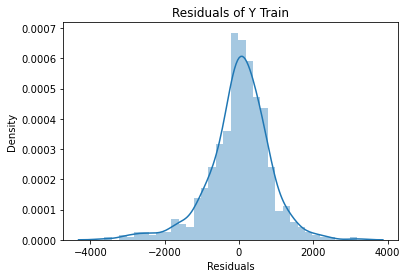

In [48]:
sns.distplot(y_train_residuals)
plt.xlabel('Residuals')
plt.title("Residuals of Y Train")

In [49]:
print(f"Skew is: {skew(y_train_residuals): .2f}")
print(f"Kurtosis is: {kurtosis(y_train_residuals): .2f}")

Skew is: -0.68
Kurtosis is:  2.35


Note:
+ Residuals are not completely normally distributed

## Check Residuals vs. Actual

Text(0.5, 1.0, 'Y Actual vs Residuals for Train data')

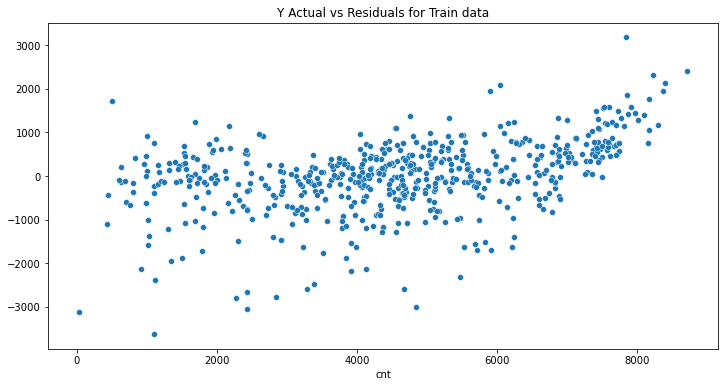

In [50]:
fig = plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_train, y=y_train_residuals)
plt.title("Y Actual vs Residuals for Train data")

Note:
+ Ideally, there should not be any pattern. 
+ But, here we can see that towards right the residuals grew, which indicates that for larger actual values there is more error. Which could mean that model is under-predicted the demand

### Q-Q Plot

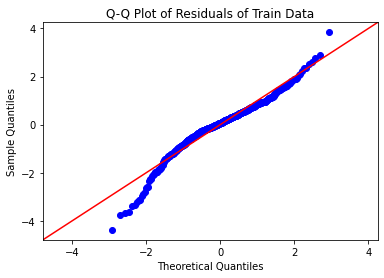

In [51]:
sm.qqplot(y_train_residuals, line ='45', fit=True, dist=stats.norm)
plt.title('Q-Q Plot of Residuals of Train Data')
plt.show()

Observation:
+ As we can clearly observe, most of the points are on the red line (y=x), but there are points far of the red lines.
This deviation from the red line shows that the residuals/points are somewhat normally distributed but not completely.

# Make Predictions on Test

In [52]:
print("Modeled columns:")
print(X_train_processed.columns)

Modeled columns:
Index(['const', 'yr', 'holiday', 'weekday', 'workingday', 'temp', 'hum',
       'windspeed', 'season_spring', 'season_summer', 'season_winter',
       'weathersit_light_rain_snow', 'weathersit_mist_cloudy'],
      dtype='object')


In [53]:
# keep only those columns on which the model was trained
X_test_processed = X_test_processed[['yr', 'holiday', 'weekday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring', 
                     'season_summer', 'season_winter', 'weathersit_light_rain_snow', 'weathersit_mist_cloudy']]
X_test_processed.head(2)

,yr,holiday,weekday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,0.976308,-0.18338,1.508722,-1.434431,-0.036858,-0.927548,0.061038,0.0,1.0,0.0,0.0,0.0
1,-1.024267,-0.18338,-1.469622,-1.434431,0.909802,1.293755,0.368750,0.0,1.0,0.0,0.0,0.0


In [54]:
# add constant
X_test_processed = sm.add_constant(X_test_processed)
X_test_processed.head(2)

,const,yr,holiday,weekday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_light_rain_snow,weathersit_mist_cloudy
0,1.0,0.976308,-0.18338,1.508722,-1.434431,-0.036858,-0.927548,0.061038,0.0,1.0,0.0,0.0,0.0
1,1.0,-1.024267,-0.18338,-1.469622,-1.434431,0.909802,1.293755,0.368750,0.0,1.0,0.0,0.0,0.0


In [55]:
# get the predictions
y_test_pred = lm_2.predict(X_test_processed)

# get the residuals
y_test_residuals = (y_test - y_test_pred)

## Residual Analysis on Test data

### Check distribution of Residuals

C:\Users\prate\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals of Y Test')

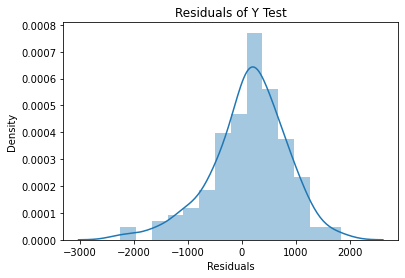

In [56]:
sns.distplot(y_test_residuals)
plt.xlabel('Residuals')
plt.title("Residuals of Y Test")

In [57]:
print(f"Skew is: {skew(y_test_residuals): .2f}")
print(f"Kurtosis is: {kurtosis(y_test_residuals): .2f}")

Skew is: -0.63
Kurtosis is:  0.98


Note:
+ Residuals are somewhat normally distributed

### Check Residuals vs Actual

Text(0.5, 1.0, 'Y Actual vs Residuals for Test data')

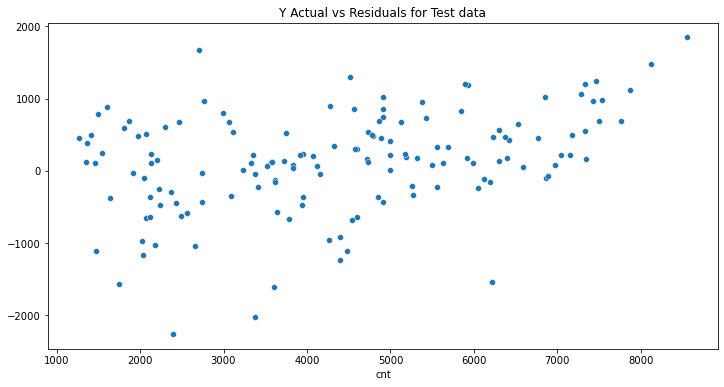

In [58]:
fig = plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_test_residuals)
plt.title("Y Actual vs Residuals for Test data")

Note:
+ For smaller values that is below 5000, there is no pattern
+ But, for values >500 the residuals are high, that is, for larger values there is higher residual

### Q-Q Plot

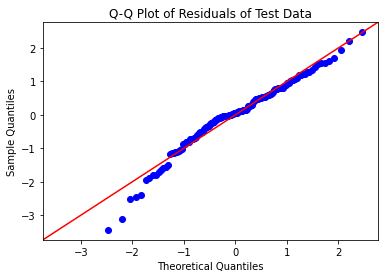

In [59]:
sm.qqplot(y_test_residuals, line ='45', fit=True, dist=stats.norm)
plt.title('Q-Q Plot of Residuals of Test Data')
plt.show()

Observation:
+ As we can clearly observe, most of the points are on the red line (y=x), but there are points far of the red lines.
This deviation from the red line shows that the residuals/points are somewhat normally distributed but not completely.


## Accuracies

In [60]:
print(f"R2 score for Train data: {r2_score(y_train, y_train_pred):.2%}")

R2 score for Train data: 82.08%


In [61]:
print(f"R2 score for Test data: {r2_score(y_test, y_test_pred):.2%}")

R2 score for Test data: 85.41%
